**CS 171 Final Project Draft**

**Status**

This is a draft of my work on my model. I had to move the computing power to Google Collab because my machine couldnt handle it. I mounted my drive so those cells will not run.

However, the process and steps I've done so far are here. I tried different implementations for the model but what this notebook contains the my last model.

This is not my final version. I still need to edit this notebook.

**Notes**

For the Final Project, we worked on a computer vision model capable of determining whether an aerial drone image contains people or no people. The goal is to create an efficient classifier suitable for real-time or near real-time applications, such as search-and-rescue drones, surveillance systems, and autonomous monitoring.

**Core Idea**

Use supervised machine learning (deep learning) to classify drone images into two categories:

*   People
*   No_people

The model learns to recognize humans from above — even when people appear extremely small, partially occluded, or blended into complex outdoor environments.

**Dataset: SARD - Search And Rescue Dataset**

Dataset From: **https://universe.roboflow.com/datasets-pdabr/sard-8xjhy**

This dataset contains multi-modal (Image / Labels) information collected from real-world images, taken by drone. It is designed to support the development and evaluation of AI models for locating, identifying, and tracking individuals in distress during disaster or emergency scenarios.

To develop the SARD dataset, the authors involved actors, who simulated exhausted and injured people and classic types of movement. The images were recorded by high resolution camera with DJI Phantom 4A Drone.


Authors suggested approach to this dataset is YOLO (You Only Look Once) models, especially v5 or v8 for detection.

Publication Date: 2025, 2 May

Classes: Human


**Data Format**

The dataset includes 5755 images.
Person are annotated in YOLOv8 format.


**Images: Train 4k, Test 0.5k, Valid 1.1k**

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

In [1]:
# Imports
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec

# packages for PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, random_split, Dataset, DataLoader, TensorDataset
import torchvision.models as models
torch.manual_seed(18);

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import os


#base = "/content/drive/MyDrive/CS171 - ML/Project/classification_dataset"
for item in os.listdir(base):
    print(item)

val_output
train_output
test_output


In [4]:
import os

!cp -r "/content/drive/MyDrive/CS171 - ML/Project/classification_dataset" "/content/data/"
base = "/content/data/"


#base = "/content/drive/MyDrive/CS171 - ML/Project/classification_dataset"
for split in ["train_output", "val_output", "test_output"]:
    path = f"{base}/{split}"
    print(f"\n{split}:")
    print(" subfolders:", os.listdir(path))



train_output:
 subfolders: ['no_people', 'people']

val_output:
 subfolders: ['no_people', 'people']

test_output:
 subfolders: ['no_people', 'people']


**Prep Files**

We'll separate files into People / No people according to the file annotation. Images without people have an empty .txt file as annotation. We must do this for all three folders: train, test and val.

In [ ]:

def split_people_not_people(images_dir, labels_dir, output_dir):
    os.makedirs(f'{output_dir}/people', exist_ok=True)
    os.makedirs(f'{output_dir}/no_people', exist_ok=True)

    for filename in os.listdir(images_dir):
        if not filename.endswith('.jpg'):
            continue

        image_path = os.path.join(images_dir, filename)
        label_path = os.path.join(labels_dir, filename.replace('.jpg', '.txt'))

        # If no annotation file exists → no_people
        if not os.path.exists(label_path):
            shutil.copy(image_path, f'{output_dir}/no_people/')
            continue

        with open(label_path, 'r') as f:
            lines = f.readlines()

        # If the file is empty → no_people
        if len(lines) == 0:
            shutil.copy(image_path, f'{output_dir}/no_people/')
            continue

        # Check if any line has class "0"
        has_person = any(line.strip().startswith('0') for line in lines)

        if has_person:
            shutil.copy(image_path, f'{output_dir}/people/')
        else:
            shutil.copy(image_path, f'{output_dir}/no_people/')


In [ ]:

#Train Folder
split_people_not_people("./search-and-rescue/train/images", "./search-and-rescue/train/labels", "train_output")
#Val
split_people_not_people("./search-and-rescue/valid/images", "./search-and-rescue/valid/labels", "val_output")
#Test
split_people_not_people("./search-and-rescue/test/images", "./search-and-rescue/test/labels", "test_output")

**Check for Duplicates in Dataset**

In [ ]:
path = "classification_dataset/train_output/people"

all_files = []
duplicates = []

for root, dirs, files in os.walk(path):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            if f in all_files:
                duplicates.append(f)
            else:
                all_files.append(f)

print("Duplicate filenames:", duplicates)

Duplicate filenames: []


**Prep Data for model Training**


*   Normalize images.Because MobileNetV2 was trained on ImageNet Data, we need to use those values for normalization. Otherwise this is inneficient.
*   Image Augmentations. This would help improve model's generalization capabilities.



In [21]:

IMG_SIZE = 224

#Param for Normalize
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

#Original Basic Image Transformations

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

'''
#Slightly Stricter Transformations
train_tfms = transforms.Compose([
    # Randomly crop & resize a bit instead of always a perfect resize
    transforms.RandomResizedCrop(
        IMG_SIZE,
        scale=(0.8, 1.0),      # zoom in up to 20%
        ratio=(0.9, 1.1),      # small aspect ratio change
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
'''

# create separate ImageFolders with their own transforms
#base = "/content/drive/MyDrive/CS171 - ML/Project/classification_dataset"
base = "/content/data"

train_dir = f"{base}/train_output"
val_dir   = f"{base}/val_output"
test_dir  = f"{base}/test_output"

#Full Data for Training
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

#Small subset of Data. During Training processing the whole data set used 100% of my CPU and caused my machine to crash.
small_train = Subset(train_ds, range(0, 500))
small_val   = Subset(val_ds,   range(0, 50))

#DataLoader. Load a small subset or Full Data
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_ds.classes
print("Train Classes:",class_names)

class_names = val_ds.classes
print("Val Classes:",class_names)

class_names = test_ds.classes
print("Test Classes:",class_names)


Train Classes: ['no_people', 'people']
Val Classes: ['no_people', 'people']
Test Classes: ['no_people', 'people']


**Training the Model**

In [22]:
# make empty lists to keep track of the training and testing losses
def training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True):
    train_losses = []
    test_losses = []

    # loop through each epoch to run the training loop
    # and check the model with the training data

    for epoch in range(NUM_EPOCHS):

        # Run the training loop
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_images = 0
        for train_inputs, train_labels in train_loader:
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()
            outputs = model(train_inputs)
            train_correct, train_total = compute_correct_labels(outputs, train_labels)
            total_train_correct += train_correct
            total_train_images += train_total
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Run the testing loop
        # this is essentially the same as the training loop but
        # without the optimizer and backward propagation
        model.eval()
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_images = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                outputs = model(test_inputs)
                test_correct, test_total = compute_correct_labels(outputs, test_labels)
                total_test_correct += test_correct
                total_test_images += test_total
                loss = criterion(outputs, test_labels)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if printing:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
                  f" - Train Loss: {avg_train_loss:.4f}, "+\
                  f"Train Correct: {total_train_correct}/{total_train_images} "+\
                  f"- Test Loss: {avg_test_loss:.4f}, "+\
                  f"Test Correct: {total_test_correct}/{total_test_images} "+\
                  f"Test Accuracy: {total_test_correct}/{total_test_images} ({total_test_correct/total_test_images:.2%})")

    return(train_losses, test_losses)

def compute_correct_labels(outputs, labels):
    correct = 0
    total = 0
    _, predicted_values = torch.max(outputs, 1)
    differences = predicted_values - labels
    for i in range(len(differences)):
        if differences[i]==0:
            correct +=1
        total += 1
    return(correct, total)

**Construct the Model**

We are using a V2 Model for this problem. The expectation is that this will perform better than a CNN created from scratch.

In [26]:
N_CLASSES = 2

criterion = nn.CrossEntropyLoss()

# Model: MobileNetV2
mobilenet = models.mobilenet_v2(
    weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
)

# Freeze feature extractor
for param in mobilenet.features[-2:].parameters():
    param.requires_grad = True

# Replace the classifier head
mobilenet.classifier[1] = nn.Linear(1280, N_CLASSES)

model = mobilenet.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training setup

NUM_EPOCHS = 20       #30 doesnt seem to improve model much more
train_losses, test_losses = training_loop(
    model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True
)

#Save Progress (Weights)
#torch.save(model.state_dict(), "/content/drive/MyDrive/CS171 - ML/Project/mobilenet_epoch10.pth") #V1. Only Augmentations.
#torch.save(model.state_dict(), "/content/drive/MyDrive/CS171 - ML/Project/mobilenet_epoch20_V2.pth") #V2.Stricter Augmented Images
torch.save(model.state_dict(), "/content/drive/MyDrive/CS171 - ML/Project/mobilenet_epoch20_V3.pth") #V3. Layers Unfrozen. Original Augmentations



Epoch 1/20 - Train Loss: 0.3344, Train Correct: 3476/4041 - Test Loss: 0.2326, Test Correct: 506/570 Test Accuracy: 506/570 (88.77%)
Epoch 2/20 - Train Loss: 0.2208, Train Correct: 3684/4041 - Test Loss: 0.1981, Test Correct: 522/570 Test Accuracy: 522/570 (91.58%)
Epoch 3/20 - Train Loss: 0.2029, Train Correct: 3686/4041 - Test Loss: 0.1925, Test Correct: 521/570 Test Accuracy: 521/570 (91.40%)
Epoch 4/20 - Train Loss: 0.1875, Train Correct: 3706/4041 - Test Loss: 0.2019, Test Correct: 527/570 Test Accuracy: 527/570 (92.46%)
Epoch 5/20 - Train Loss: 0.1830, Train Correct: 3732/4041 - Test Loss: 0.2020, Test Correct: 524/570 Test Accuracy: 524/570 (91.93%)
Epoch 6/20 - Train Loss: 0.1738, Train Correct: 3715/4041 - Test Loss: 0.1477, Test Correct: 536/570 Test Accuracy: 536/570 (94.04%)
Epoch 7/20 - Train Loss: 0.1627, Train Correct: 3750/4041 - Test Loss: 0.1682, Test Correct: 531/570 Test Accuracy: 531/570 (93.16%)
Epoch 8/20 - Train Loss: 0.1704, Train Correct: 3741/4041 - Test Loss

**Asses Model Performance**

In [16]:
print("Train classes:", train_ds.classes)
print("Test classes:",  test_ds.classes)

print("Train size:", len(train_ds))
print("Test size:",  len(test_ds))

Train classes: ['no_people', 'people']
Test classes: ['no_people', 'people']
Train size: 4041
Test size: 570


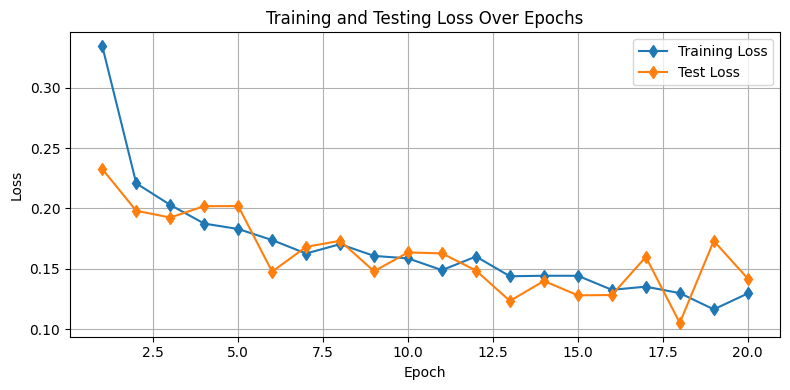

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Peek Into Classifications:

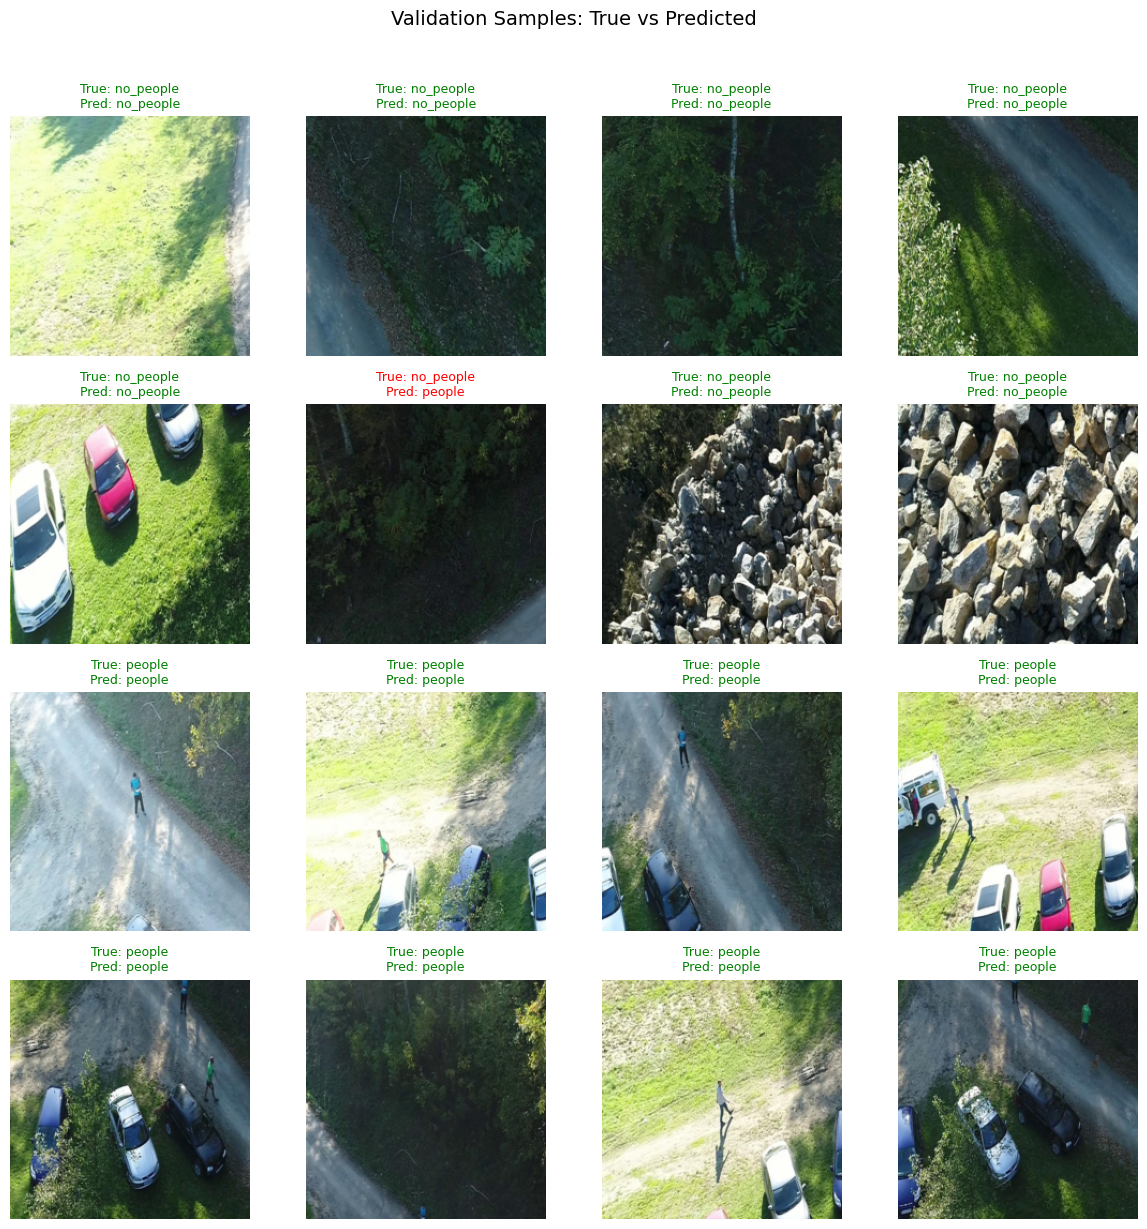

In [30]:
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

# --- Config ---
K = 8  # images per class to show
classes = class_names       # assume len(classes) == 2
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

rows, cols = 4, 4  # 4x4 grid = 16 images total

# De-normalize a single image
def denorm_img(img_t):
    img = img_t.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * std) + mean
    return np.clip(img, 0, 1)

model.eval()

fig = plt.figure(figsize=(3*cols, 3*rows))
gs = gridspec.GridSpec(rows, cols, figure=fig)

# how many we've shown per class (0 and 1)
shown = {0: 0, 1: 0}
total_needed = K * 2  # 16
colormap = {True: "green", False: "red"}

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(images.size(0)):
            true_c = labels[i].item()
            if true_c not in shown:
                continue  # just in case, but should be 0 or 1

            if shown[true_c] >= K:
                continue  # already have enough for this class

            # Compute position in the 4x4 grid
            # First 8 (indices 0–7) are class 0, next 8 (8–15) are class 1
            if true_c == 0:
                idx = shown[0]                    # 0..7
            else:
                idx = K + shown[1]                # 8..15

            row, col = divmod(idx, cols)
            ax = fig.add_subplot(gs[row, col])

            ax.imshow(denorm_img(images[i]))
            ax.axis('off')

            correct = (preds[i].item() == true_c)
            title = f"True: {classes[true_c]}\nPred: {classes[preds[i].item()]}"
            ax.set_title(title, color=colormap[correct], fontsize=9)

            shown[true_c] += 1
            total_needed -= 1

            if total_needed == 0:
                break
        if total_needed == 0:
            break

plt.suptitle("Validation Samples: True vs Predicted", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


**Comments on the model**

**First Model** relied primarly on image augmentations for better generalization and accuracy. Model did not overfit although there was noise present in the dataset. I ran 30 epochs but model stopped improving around 18 epochs so I decided to keept it at 20. Most of the misclassification were false positives (predicting “people” when no people were present). For applications such as rescue or surveillance, this behavior is generally preferable to false negatives, as missing a person can be more costly than raising a false alarm. The model reached a 89% accuracy.

For the **second Model**, I used different parameters during the image augmentations. I thought this would increase accuracy but it was the opposite. During the V2 testing accuracy dropped to 83%. Both training and validation losses stayed close, indicating neither overfitting nor underfitting. My conclusion was that these stronger augmentations distorted the images in ways that did not benefit the learning process, reducing the model’s ability to extract useful patterns from the data.Since the images were not improving acuracy, my next idea was to focus on the Model implementation instead.

Finally, Since the model had no sign of overfitting or underfitting, I did not add dropout or change the LR. Instead, I revisited the model architecture itself. Until this point, I had only trained the final classifier head, leaving the rest of MobileNetV2 frozen with ImageNet weights. This limited how much the model could adapt to the unique characteristics of aerial, small-scale pedestrian images. To address this, I unfroze the final two MobileNetV2 blocks and allowed them to fine-tune on our dataset. This increased the accuracy to 94%.

This demonstrates that partial fine-tuning—combined with balanced augmentations is essential for adapting a pretrained model to a domain that differs from natural ImageNet images.
